In [2]:
import torch
import pytorch_lightning as pl
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger
from ray import air, tune
import ray
from ray.air.config import RunConfig, ScalingConfig, CheckpointConfig
from ray.train.lightning import LightningTrainer, LightningConfigBuilder
import numpy as np
import os
import torch.nn.functional as F
from pytorch_lightning.callbacks import RichProgressBar
import tensorboard
import pandas as pd
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from sam import SAM
from pytorch_optimizer import AvaGrad 
import warnings

## Pytorch Lightning Modules

### Data Module

In [2]:
class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, batch_size=64, cwd=None):
        super().__init__()
        self.batch_size = batch_size
        self.data_path = os.path.join(cwd, "data")
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def prepare_data(self):
        datasets.CIFAR10(root=self.data_path, train=True, download=True)
        datasets.CIFAR10(root=self.data_path, train=False, download=True)

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.cifar10_train = datasets.CIFAR10(root=self.data_path, train=True, transform=self.transform)
            self.cifar10_val = datasets.CIFAR10(root=self.data_path, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.cifar10_train, batch_size=self.batch_size, num_workers=1, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.cifar10_val, batch_size=self.batch_size, num_workers=1, shuffle=True)

### Networks

In [3]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        # Reduced the number of output channels
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # Reduced the input features of the fully connected layer
        self.fc1 = nn.Linear(32 * 16 * 16, 64) # reduced from 128 to 64
        self.fc2 = nn.Linear(64, 10) # output layer remains the same

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16) # match the number of output channels from conv2
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [9]:
class SmallNetLightning(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        #self.model = torchvision.models.resnet18()
        self.model = SmallNet()
        #num_ftrs = self.model.fc.in_features
        #self.model.fc = nn.Linear(num_ftrs, 10)  # CIFAR10 has 10 classes
        self.loss = torch.nn.CrossEntropyLoss()
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.automatic_optimization = False
        if self.config["SAM"]:
            self.optimizer = SAM(self.model.parameters(), self.config["optimizer"], **self.config["parameters"])
        else:
            self.optimizer = self.config["optimizer"](self.model.parameters(), **self.config["parameters"])
        
        
        
    def forward(self, x):
        return self.model(x)
    
    
    def training_step(self, batch, batch_idx):
        
        optimizer = self.optimizers()
        x, y = batch
        
        def closure():
            loss = self.loss(self.model(x), y)
            optimizer.zero_grad()
            self.manual_backward(loss)
            return loss
        
        loss = self.loss(self.model(x), y)
        self.log('train_loss', loss, prog_bar=True, logger=True, on_step=False, on_epoch=True, sync_dist=True)

        optimizer.zero_grad()
        self.manual_backward(loss)

        if self.config["SAM"]:
            optimizer.step(closure)
        else:
            optimizer.step()
        
        return loss
        
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        self.log('val_loss', loss, prog_bar=True, logger=True, on_step=False, on_epoch=True, sync_dist=True)
        return loss
    
    
    def configure_optimizers(self):
        # takes the constructor of the optimizer as input (for example torch.optim.Adam)
        if self.config["SAM"]:
            optimizer = SAM(self.model.parameters(), self.config["optimizer"], **self.config["parameters"])
        else:
            optimizer = self.config["optimizer"](self.model.parameters(), **self.config["parameters"])
        return optimizer

## Hyperparameter Search with Ray

In [5]:
def train(batch_size=64, epochs=10, config=None, accelerator="cuda" if torch.cuda.is_available() else "cpu", num_workers=1, cwd=None, logger_name="my_model", train_batches_per_epoch=0.1, val_batches_per_epoch=0.2):
    '''
    batch_size: batch size for training
    config: dictionary containing the optimizer and its parameters
    accelerator: "cuda" or "cpu"
    num_workers: number of parallel trials to run (each trial uses 1 cpu core and 1 gpu core, if available)
    cwd: current working directory
    logger_name: name of the directory (used for tensorboard and csv logs)
    train_batches_per_epoch: fraction of training data to use per epoch
    val_batches_per_epoch: fraction of validation data to use per epoch
    '''
    
    torch.manual_seed(42)
    
    data_module = CIFAR10DataModule(batch_size=batch_size, cwd=cwd)
    #logger = TensorBoardLogger(os.path.join(cwd,"tensorboard_logs"), name=logger_name)
    logger = CSVLogger(os.path.join(cwd,"csv_logs"), name=logger_name)
    #tune_logger = TuneReportCallback(["train_loss, val_loss"], on="on_test_epoch_end")
    
    lightning_config = (
        LightningConfigBuilder()
        .module(cls=SmallNetLightning, config=config)
        .trainer(max_epochs=epochs, accelerator=accelerator, logger=None, callbacks=[RichProgressBar(leave=True)], limit_train_batches=train_batches_per_epoch, limit_val_batches=val_batches_per_epoch)
        .fit_params(datamodule=data_module)
        #.checkpointing(monitor="val_loss", save_top_k=0, mode="min")
        .build()
    )

    run_config = RunConfig(
        # checkpoint_config=CheckpointConfig(
        #     num_to_keep=1,
        #     checkpoint_score_attribute="val_loss",
        #     checkpoint_score_order="min",
        #  ),
    )

    scaling_config = ScalingConfig(
        num_workers=num_workers, resources_per_worker={"CPU": 1, "GPU": 1 if accelerator=="cuda" else 0}
    )

    # Define a base LightningTrainer without hyper-parameters for Tuner
    lightning_trainer = LightningTrainer(
        scaling_config=scaling_config,
        run_config=run_config,
    )   

    tuner = tune.Tuner(
        lightning_trainer,
        param_space={"lightning_config": lightning_config},
        tune_config=tune.TuneConfig(
            max_concurrent_trials=1,
            metric="val_loss",
            mode="min",
            #num_samples=num_samples,
        ),
        run_config=air.RunConfig(
            storage_path=cwd,
            name="tune_cifar10",
        ),
    )
    results = tuner.fit()
    #best_result = results.get_best_result(metric="val_loss", mode="max")
    return results

## Example Experiment

In [14]:
ray.init(ignore_reinit_error=True)

"""
The tune gridsearch will try all possible combinations of the parameters in the config dictionary.
By using the np.logspace function we can define a range of values to try for each parameter.
The argument "num" defines the number of values to try in the range.
    
"""

config = {
    "optimizer": torch.optim.SGD,
    "SAM":False,
    "parameters":{
        "lr": tune.grid_search(np.logspace(-1, -6, num=2)),
        "weight_decay": tune.grid_search(np.logspace(-1, -6, num=2)),
    }
}

result_grid = train(config=config, epochs=5, num_workers=1, cwd=os.path.join(os.getcwd()), logger_name="SmallNet", train_batches_per_epoch=0.01, val_batches_per_epoch=0.1)

2023-06-26 14:18:26,181	INFO worker.py:1474 -- Calling ray.init() again after it has already been called.


(LightningTrainer pid=16702) 2023-06-26 14:18:30,890	INFO backend_executor.py:137 -- Starting distributed worker processes: ['16752 (192.168.2.113)']
(RayTrainWorker pid=16752) 2023-06-26 14:18:32,198	INFO config.py:86 -- Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=16752) GPU available: False, used: False
(RayTrainWorker pid=16752) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=16752) IPU available: False, using: 0 IPUs
(RayTrainWorker pid=16752) HPU available: False, using: 0 HPUs


(RayTrainWorker pid=16752) Files already downloaded and verified
(RayTrainWorker pid=16752) Files already downloaded and verified


(RayTrainWorker pid=16752) Missing logger folder: /home/raffi/Projects/OPT4ML-project/tune_cifar10/LightningTrainer_8d476_00000_0_lr=0.1000,weight_decay=0.1000_2023-06-26_14-18-26/rank_0/lightning_logs


(RayTrainWorker pid=16752) ┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
(RayTrainWorker pid=16752) ┃   ┃ Name  ┃ Type             ┃ Params ┃
(RayTrainWorker pid=16752) ┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
(RayTrainWorker pid=16752) │ 0 │ model │ SmallNet         │  530 K │
(RayTrainWorker pid=16752) │ 1 │ loss  │ CrossEntropyLoss │      0 │
(RayTrainWorker pid=16752) └───┴───────┴──────────────────┴────────┘
(RayTrainWorker pid=16752) Trainable params: 530 K                                                         
(RayTrainWorker pid=16752) Non-trainable params: 0                                                         
(RayTrainWorker pid=16752) Total params: 530 K                                                             
(RayTrainWorker pid=16752) Total estimated model params size (MB): 2                                       
(RayTrainWorker pid=16752) 


(RayTrainWorker pid=16752) E0626 14:18:34.939264185   16807 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(RayTrainWorker pid=16752) E0626 14:18:35.075381265   16807 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


/home/raffi/mambaforge/envs/opt4ml/lib/python3.10/site-packages/pytorch_lightnin
(RayTrainWorker pid=16752) g/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your 
(RayTrainWorker pid=16752) `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended 
(RayTrainWorker pid=16752) that you turn shuffling off for val/test dataloaders.
(RayTrainWorker pid=16752)   rank_zero_warn(
/home/raffi/mambaforge/envs/opt4ml/lib/python3.10/site-packages/pytorch_lightnin
(RayTrainWorker pid=16752) g/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader,
(RayTrainWorker pid=16752) val_dataloader, does not have many workers which may be a bottleneck. Consider 
(RayTrainWorker pid=16752) increasing the value of the `num_workers` argument` (try 16 which is the number 
(RayTrainWorker pid=16752) of cpus on this machine) in the `DataLoader` init to improve performance.
(RayTrainWorker pid=16752)   rank_zero_warn(
(RayTrainWorker pid=16752) 


(RayTrainWorker pid=16752) E0626 14:18:35.277536802   16807 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(RayTrainWorker pid=16752) E0626 14:18:35.375545359   16807 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Sanity Checking ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:00 • 0:00:00 27.39it/s 0.00it/s 
/home/raffi/mambaforge/envs/opt4ml/lib/python3.10/site-packages/pytorch_lightnin
(RayTrainWorker pid=16752) g/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader,
(RayTrainWorker pid=16752) train_dataloader, does not have many workers which may be a bottleneck. Consider
(RayTrainWorker pid=16752) increasing the value of the `num_workers` argument` (try 16 which is the number 
(RayTrainWorker pid=16752) of cpus on this machine) in the `DataLoader` init to improve performance.
(RayTrainWorker pid=16752)   rank_zero_warn(
/home/raffi/mambaforge/envs/opt4ml/lib/python3.10/site-packages/pytorch_lightnin
(RayTrainWorker pid=16752) g/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (7)
(RayTrainWorker pid=16752) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 
(RayTrainWorker pid=16752) value for log_every_n_steps if you w

(RayTrainWorker pid=16752) E0626 14:18:36.025410538   16807 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 13.00it/s v_num: 0 v_num: 0 
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 13.00it/s v_num: 0 
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 13.00it/s v_num: 0 
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 13.00it/s v_num: 0 -:-- 0.00it/s           
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 13.00it/s v_num: 0 -:-- 0.00it/s           
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 13.00it/s v_num: 0 0:01 26.32it/s          
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 13.00it/s v_num: 0 0:01 26.32it/s          
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 13.00it/s v_num: 0 0:01 26.66it/s          
(RayTrainWorker pid=16752) Validation ━━━━━╺━━━━━━━━━━━━━━━━━━━━ 3/15 0:00:00 • 0:00:01 26.66it/s          
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 13.00it/s v_num: 0 
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━

Trial name,_report_on,date,done,epoch,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,step,time_since_restore,time_this_iter_s,time_total_s,timestamp,train_loss,training_iteration,trial_id,val_loss
LightningTrainer_8d476_00000,train_epoch_end,2023-06-26_14-18-43,True,4,"0_lr=0.1000,weight_decay=0.1000",thinkpad-t14s,5,192.168.2.113,16702,True,35,14.356,1.70478,14.356,1687781923,2.23966,5,8d476_00000,2.21652
LightningTrainer_8d476_00001,train_epoch_end,2023-06-26_14-19-02,True,4,"1_lr=0.0000,weight_decay=0.1000",thinkpad-t14s,5,192.168.2.113,17234,True,35,13.9723,1.64173,13.9723,1687781942,2.30332,5,8d476_00001,2.30132
LightningTrainer_8d476_00002,train_epoch_end,2023-06-26_14-19-22,True,4,"2_lr=0.1000,weight_decay=0.0000",thinkpad-t14s,5,192.168.2.113,17738,True,35,14.3125,1.73064,14.3125,1687781962,2.19212,5,8d476_00002,2.14564
LightningTrainer_8d476_00003,train_epoch_end,2023-06-26_14-19-42,True,4,"3_lr=0.0000,weight_decay=0.0000",thinkpad-t14s,5,192.168.2.113,18217,True,35,14.0129,1.38377,14.0129,1687781982,2.31268,5,8d476_00003,2.30412


Epoch 1/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:00 • -:--:-- 0.00it/s v_num: 0 val_loss: 
(RayTrainWorker pid=16752)                                                              2.291 train_loss:  
(RayTrainWorker pid=16752)                                                              2.302              
Epoch 1/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:00 • 0:00:01 12.21it/s v_num: 0 val_loss:
(RayTrainWorker pid=16752)                                                               2.291 train_loss: 
Epoch 1/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:00 • 0:00:01 12.21it/s v_num: 0 val_loss:
(RayTrainWorker pid=16752)                                                               2.291 train_loss: 
Epoch 1/4  ━━━━━━━╸━━━━━━━━━━ 3/7 0:00:00 • 0:00:01 11.94it/s v_num: 0 val_loss:
(RayTrainWorker pid=16752)                                                               2.291 train_loss: 
Epoch 1/4  ━━━━━━━╸━━━━━━━━━━ 3/7 0:00:00 • 0:00:01 11.94it/s v_num: 0 val_loss:
(RayTrainWorker pid=16752)                             

(RayTrainWorker pid=16752) E0626 14:18:39.215271479   16807 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 2/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 11.87it/s v_num: 0 val_loss:
(RayTrainWorker pid=16752)                                                               2.269 train_loss: 
Epoch 2/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 11.87it/s v_num: 0 val_loss:
(RayTrainWorker pid=16752)                                                               2.269 train_loss: 
(RayTrainWorker pid=16752)                                                               2.281             
Epoch 2/4  ━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.87it/s v_num: 0 val_loss:
(RayTrainWorker pid=16752)                                                               2.269 train_loss: 
(RayTrainWorker pid=16752)                                                               2.281             
Epoch 2/4  ━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.87it/s v_num: 0 val_loss:0m                   
(RayTrainWorker pid=16752)                                                               2.269 train_loss: 
(RayTra

(RayTrainWorker pid=16752) E0626 14:18:40.223260265   16807 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 2/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 11.87it/s v_num: 0 val_loss:
(RayTrainWorker pid=16752)                                                               2.261 train_loss: 
(RayTrainWorker pid=16752)                                                               2.275             
Epoch 3/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/7 0:00:00 • -:--:-- 0.00it/s 
Epoch 3/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:00 • -:--:-- 0.00it/s v_num: 0 val_loss: 
(RayTrainWorker pid=16752)                                                              2.261 train_loss:  
(RayTrainWorker pid=16752)                                                              2.275              
Epoch 3/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:00 • 0:00:01 11.59it/s v_num: 0 val_loss:
(RayTrainWorker pid=16752)                                                               2.261 train_loss: 
Epoch 3/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:00 • 0:00:01 11.59it/s v_num: 0 val_loss:
(RayTrainWorker pid=16752)                              

(RayTrainWorker pid=16752) E0626 14:18:40.937826368   16807 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 3/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 12.07it/s v_num: 0 val_loss:
(RayTrainWorker pid=16752)                                                               2.261 train_loss: 
Epoch 3/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 12.07it/s v_num: 0 val_loss:
(RayTrainWorker pid=16752)                                                               2.261 train_loss: 
(RayTrainWorker pid=16752)                                                               2.275             
Epoch 3/4  ━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 12.07it/s v_num: 0 val_loss:
(RayTrainWorker pid=16752)                                                               2.261 train_loss: 
(RayTrainWorker pid=16752)                                                               2.275             
Epoch 3/4  ━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 12.07it/s v_num: 0 val_loss:0m                   
(RayTrainWorker pid=16752)                                                               2.261 train_loss: 
(RayTra

(RayTrainWorker pid=16752) E0626 14:18:41.812219602   16807 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 4/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:00 • -:--:-- 0.00it/s v_num: 0 val_loss: 
(RayTrainWorker pid=16752)                                                              2.236 train_loss:  
(RayTrainWorker pid=16752)                                                              2.252              
Epoch 4/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:00 • 0:00:01 11.39it/s v_num: 0 val_loss:
(RayTrainWorker pid=16752)                                                               2.236 train_loss: 
Epoch 4/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:00 • 0:00:01 11.39it/s v_num: 0 val_loss:
(RayTrainWorker pid=16752)                                                               2.236 train_loss: 
(RayTrainWorker pid=16752)                                                               2.252             
Epoch 4/4  ━━━━━━━╸━━━━━━━━━━ 3/7 0:00:00 • 0:00:01 11.40it/s v_num: 0 val_loss:
(RayTrainWorker pid=16752)                                                               2.236 train_loss: 
Epoch 4/4  ━━━━━━━╸━━━━━━━━━

(RayTrainWorker pid=16752) `Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 11.54it/s v_num: 0 val_loss:
(RayTrainWorker pid=16752)                                                               2.217 train_loss: 
(RayTrainWorker pid=16752)                                                               2.24              
(RayTrainWorker pid=16752) 


(LightningTrainer pid=17234) 2023-06-26 14:18:50,379	INFO backend_executor.py:137 -- Starting distributed worker processes: ['17284 (192.168.2.113)']
(RayTrainWorker pid=17284) 2023-06-26 14:18:51,591	INFO config.py:86 -- Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=17284) GPU available: False, used: False
(RayTrainWorker pid=17284) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=17284) IPU available: False, using: 0 IPUs
(RayTrainWorker pid=17284) HPU available: False, using: 0 HPUs


(RayTrainWorker pid=17284) Files already downloaded and verified
(RayTrainWorker pid=17284) Files already downloaded and verified


(RayTrainWorker pid=17284) Missing logger folder: /home/raffi/Projects/OPT4ML-project/tune_cifar10/LightningTrainer_8d476_00001_1_lr=0.0000,weight_decay=0.1000_2023-06-26_14-18-45/rank_0/lightning_logs
(RayTrainWorker pid=17284) E0626 14:18:54.200865509   17330 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(RayTrainWorker pid=17284) ┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
(RayTrainWorker pid=17284) ┃   ┃ Name  ┃ Type             ┃ Params ┃
(RayTrainWorker pid=17284) ┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
(RayTrainWorker pid=17284) │ 0 │ model │ SmallNet         │  530 K │
(RayTrainWorker pid=17284) │ 1 │ loss  │ CrossEntropyLoss │      0 │
(RayTrainWorker pid=17284) └───┴───────┴──────────────────┴────────┘
(RayTrainWorker pid=17284) Trainable params: 530 K                                                         
(RayTrainWorker pid=17284) Non-trainable params: 0                                                         
(RayTrainWorker pid=17284) Total params: 530 K                                                             
(RayTrainWorker pid=17284) Total estimated model params size (MB): 2                                       
(RayTrainWorker pid=17284) 


(RayTrainWorker pid=17284) E0626 14:18:54.364225227   17330 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


/home/raffi/mambaforge/envs/opt4ml/lib/python3.10/site-packages/pytorch_lightnin
(RayTrainWorker pid=17284) g/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your 
(RayTrainWorker pid=17284) `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended 
(RayTrainWorker pid=17284) that you turn shuffling off for val/test dataloaders.
(RayTrainWorker pid=17284)   rank_zero_warn(
/home/raffi/mambaforge/envs/opt4ml/lib/python3.10/site-packages/pytorch_lightnin
(RayTrainWorker pid=17284) g/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader,
(RayTrainWorker pid=17284) val_dataloader, does not have many workers which may be a bottleneck. Consider 
(RayTrainWorker pid=17284) increasing the value of the `num_workers` argument` (try 16 which is the number 
(RayTrainWorker pid=17284) of cpus on this machine) in the `DataLoader` init to improve performance.
(RayTrainWorker pid=17284)   rank_zero_warn(
(RayTrainWorker pid=17284) 


(RayTrainWorker pid=17284) E0626 14:18:54.616285949   17330 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Sanity Checking ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:00 • 0:00:00 24.30it/s 0.00it/s 


(RayTrainWorker pid=17284) E0626 14:18:54.760290312   17330 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


/home/raffi/mambaforge/envs/opt4ml/lib/python3.10/site-packages/pytorch_lightnin
(RayTrainWorker pid=17284) g/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader,
(RayTrainWorker pid=17284) train_dataloader, does not have many workers which may be a bottleneck. Consider
(RayTrainWorker pid=17284) increasing the value of the `num_workers` argument` (try 16 which is the number 
(RayTrainWorker pid=17284) of cpus on this machine) in the `DataLoader` init to improve performance.
(RayTrainWorker pid=17284)   rank_zero_warn(
/home/raffi/mambaforge/envs/opt4ml/lib/python3.10/site-packages/pytorch_lightnin
(RayTrainWorker pid=17284) g/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (7)
(RayTrainWorker pid=17284) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 
(RayTrainWorker pid=17284) value for log_every_n_steps if you want to see logs for the training epoch.
(RayTrainWorker pid=17284)   rank_zero_warn(
Epoc

(RayTrainWorker pid=17284) E0626 14:18:55.533254044   17330 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 11.93it/s v_num: 0 
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.93it/s v_num: 0 
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.93it/s v_num: 0 -:-- 0.00it/s           
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.93it/s v_num: 0 -:-- 0.00it/s           
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.93it/s v_num: 0 0:01 23.37it/s          
(RayTrainWorker pid=17284) Validation ━━━╺━━━━━━━━━━━━━━━━━━━━━━ 2/15 0:00:00 • 0:00:01 23.37it/s          
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.93it/s v_num: 0 
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.93it/s v_num: 0 0:01 25.35it/s          
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.93it/s v_num: 0 0:01 25.35it/s          
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.93it/s v_num: 0 0:01 26.50it/s          
Epoch 0/4  ━━━━━━━━

(RayTrainWorker pid=17284) E0626 14:18:57.127446116   17330 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 1/4  ━━━━━━━━━━━━━━━╺━━ 6/7 0:00:00 • 0:00:01 12.79it/s v_num: 0 val_loss:
(RayTrainWorker pid=17284)                                                               2.303 train_loss: 
Epoch 1/4  ━━━━━━━━━━━━━━━╺━━ 6/7 0:00:00 • 0:00:01 12.79it/s v_num: 0 val_loss:
(RayTrainWorker pid=17284)                                                               2.303 train_loss: 
Epoch 1/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 12.97it/s v_num: 0 val_loss:
(RayTrainWorker pid=17284)                                                               2.303 train_loss: 
Epoch 1/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 12.97it/s v_num: 0 val_loss:
(RayTrainWorker pid=17284)                                                               2.303 train_loss: 
(RayTrainWorker pid=17284)                                                               2.307             
Epoch 1/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 12.97it/s v_num: 0 val_loss:
(RayTrainWorker pid=17284)                             

(RayTrainWorker pid=17284) E0626 14:18:58.035665232   17330 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 2/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:00 • -:--:-- 0.00it/s v_num: 0 val_loss: 
(RayTrainWorker pid=17284)                                                              2.305 train_loss:  
(RayTrainWorker pid=17284)                                                              2.302              
Epoch 2/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:00 • 0:00:01 10.52it/s v_num: 0 val_loss:
(RayTrainWorker pid=17284)                                                               2.305 train_loss: 
Epoch 2/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:00 • 0:00:01 10.52it/s v_num: 0 val_loss:
(RayTrainWorker pid=17284)                                                               2.305 train_loss: 
(RayTrainWorker pid=17284)                                                               2.302             
Epoch 2/4  ━━━━━━━╸━━━━━━━━━━ 3/7 0:00:00 • 0:00:01 10.19it/s v_num: 0 val_loss:
(RayTrainWorker pid=17284)                                                               2.305 train_loss: 
Epoch 2/4  ━━━━━━━╸━━━━━━━━━

(RayTrainWorker pid=17284) E0626 14:18:58.760007533   17330 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 2/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 11.85it/s v_num: 0 val_loss:
(RayTrainWorker pid=17284)                                                               2.305 train_loss: 
Epoch 2/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 11.85it/s v_num: 0 val_loss:
(RayTrainWorker pid=17284)                                                               2.305 train_loss: 
Epoch 2/4  ━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.85it/s v_num: 0 val_loss:
(RayTrainWorker pid=17284)                                                               2.305 train_loss: 
(RayTrainWorker pid=17284)                                                               2.302             
Epoch 2/4  ━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.85it/s v_num: 0 val_loss:0m                   
(RayTrainWorker pid=17284)                                                               2.305 train_loss: 
(RayTrainWorker pid=17284)                                                               2.302             
(RayTra

(RayTrainWorker pid=17284) E0626 14:19:00.347925565   17330 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 3/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 12.39it/s v_num: 0 val_loss:
(RayTrainWorker pid=17284)                                                               2.303 train_loss: 
Epoch 3/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 12.39it/s v_num: 0 val_loss:
(RayTrainWorker pid=17284)                                                               2.303 train_loss: 
Epoch 3/4  ━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 12.39it/s v_num: 0 val_loss:
(RayTrainWorker pid=17284)                                                               2.303 train_loss: 
(RayTrainWorker pid=17284)                                                               2.307             
Epoch 3/4  ━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 12.39it/s v_num: 0 val_loss:0m                   
(RayTrainWorker pid=17284)                                                               2.303 train_loss: 
(RayTrainWorker pid=17284)                                                               2.307             
Epoch 3

(RayTrainWorker pid=17284) E0626 14:19:02.051667924   17330 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 4/4  ━━━━━━━━━━━━━━━╺━━ 6/7 0:00:00 • 0:00:01 11.89it/s v_num: 0 val_loss:
(RayTrainWorker pid=17284)                                                               2.305 train_loss: 
Epoch 4/4  ━━━━━━━━━━━━━━━╺━━ 6/7 0:00:00 • 0:00:01 11.89it/s v_num: 0 val_loss:
(RayTrainWorker pid=17284)                                                               2.305 train_loss: 
Epoch 4/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 12.24it/s v_num: 0 val_loss:
(RayTrainWorker pid=17284)                                                               2.305 train_loss: 
Epoch 4/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 12.24it/s v_num: 0 val_loss:
(RayTrainWorker pid=17284)                                                               2.305 train_loss: 
(RayTrainWorker pid=17284)                                                               2.311             
Epoch 4/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 12.24it/s v_num: 0 val_loss:
(RayTrainWorker pid=17284)                             

(RayTrainWorker pid=17284) `Trainer.fit` stopped: `max_epochs=5` reached.
(LightningTrainer pid=17738) 2023-06-26 14:19:09,830	INFO backend_executor.py:137 -- Starting distributed worker processes: ['17778 (192.168.2.113)']
(RayTrainWorker pid=17778) 2023-06-26 14:19:11,076	INFO config.py:86 -- Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=17778) GPU available: False, used: False
(RayTrainWorker pid=17778) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=17778) IPU available: False, using: 0 IPUs
(RayTrainWorker pid=17778) HPU available: False, using: 0 HPUs


(RayTrainWorker pid=17778) Files already downloaded and verified
(RayTrainWorker pid=17778) Files already downloaded and verified


(RayTrainWorker pid=17778) Missing logger folder: /home/raffi/Projects/OPT4ML-project/tune_cifar10/LightningTrainer_8d476_00002_2_lr=0.1000,weight_decay=0.0000_2023-06-26_14-19-05/rank_0/lightning_logs
(RayTrainWorker pid=17778) E0626 14:19:13.818044156   17829 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(RayTrainWorker pid=17778) E0626 14:19:13.910426467   17829 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(RayTrainWorker pid=17778) ┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
(RayTrainWorker pid=17778) ┃   ┃ Name  ┃ Type             ┃ Params ┃
(RayTrainWorker pid=17778) ┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
(RayTrainWorker pid=17778) │ 0 │ model │ SmallNet         │  530 K │
(RayTrainWorker pid=17778) │ 1 │ loss  │ CrossEntropyLoss │      0 │
(RayTrainWorker pid=17778) └───┴───────┴──────────────────┴────────┘
(RayTrainWorker pid=17778) Trainable params: 530 K                                                         
(RayTrainWorker pid=17778) Non-trainable params: 0                                                         
(RayTrainWorker pid=17778) Total params: 530 K                                                             
(RayTrainWorker pid=17778) Total estimated model params size (MB): 2                                       
(RayTrainWorker pid=17778) 
/home/raffi/mambaforge/envs/opt4ml/lib/python3.10/site-packages/pytorch_lightnin
(RayTrainWorker pid=17778) g/trainer/connecto

(RayTrainWorker pid=17778) E0626 14:19:14.192653674   17829 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(RayTrainWorker pid=17778) E0626 14:19:14.337465361   17829 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


/home/raffi/mambaforge/envs/opt4ml/lib/python3.10/site-packages/pytorch_lightnin
(RayTrainWorker pid=17778) g/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader,
(RayTrainWorker pid=17778) train_dataloader, does not have many workers which may be a bottleneck. Consider
(RayTrainWorker pid=17778) increasing the value of the `num_workers` argument` (try 16 which is the number 
(RayTrainWorker pid=17778) of cpus on this machine) in the `DataLoader` init to improve performance.
(RayTrainWorker pid=17778)   rank_zero_warn(
/home/raffi/mambaforge/envs/opt4ml/lib/python3.10/site-packages/pytorch_lightnin
(RayTrainWorker pid=17778) g/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (7)
(RayTrainWorker pid=17778) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 
(RayTrainWorker pid=17778) value for log_every_n_steps if you want to see logs for the training epoch.
(RayTrainWorker pid=17778)   rank_zero_warn(
Epoc

(RayTrainWorker pid=17778) E0626 14:19:15.069496531   17829 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.59it/s v_num: 0 
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.59it/s v_num: 0 -:-- 0.00it/s           
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.59it/s v_num: 0 -:-- 0.00it/s           
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.59it/s v_num: 0 0:01 27.25it/s          
(RayTrainWorker pid=17778) Validation ━━━╺━━━━━━━━━━━━━━━━━━━━━━ 2/15 0:00:00 • 0:00:01 27.25it/s          
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.59it/s v_num: 0 
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.59it/s v_num: 0 0:01 27.87it/s          
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.59it/s v_num: 0 0:01 27.87it/s          
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.59it/s v_num: 0 0:01 27.94it/s          
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.59it/s v_num: 0 0:01 27.94it/s      

(RayTrainWorker pid=17778) E0626 14:19:16.017526612   17829 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 0/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 11.59it/s v_num: 0 val_loss:
(RayTrainWorker pid=17778)                                                               2.289 train_loss: 
(RayTrainWorker pid=17778)                                                               2.3               
Epoch 1/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/7 0:00:00 • -:--:-- 0.00it/s 
Epoch 1/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:00 • -:--:-- 0.00it/s v_num: 0 val_loss: 
(RayTrainWorker pid=17778)                                                              2.289 train_loss:  
(RayTrainWorker pid=17778)                                                              2.3                
Epoch 1/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:00 • 0:00:01 11.64it/s v_num: 0 val_loss:
(RayTrainWorker pid=17778)                                                               2.289 train_loss: 
Epoch 1/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:00 • 0:00:01 11.64it/s v_num: 0 val_loss:
(RayTrainWorker pid=17778)                              

(RayTrainWorker pid=17778) E0626 14:19:16.792978099   17829 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 1/4  ━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.02it/s v_num: 0 val_loss:
(RayTrainWorker pid=17778)                                                               2.289 train_loss: 
(RayTrainWorker pid=17778)                                                               2.3               
Epoch 1/4  ━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.02it/s v_num: 0 val_loss:0m                   
(RayTrainWorker pid=17778)                                                               2.289 train_loss: 
(RayTrainWorker pid=17778)                                                               2.3               
Epoch 1/4  ━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.02it/s v_num: 0 val_loss:0m                   
(RayTrainWorker pid=17778)                                                               2.289 train_loss: 
(RayTrainWorker pid=17778)                                                               2.3               
Epoch 1/4  ━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.02it/s v_num

(RayTrainWorker pid=17778) E0626 14:19:17.705330675   17829 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 1/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 11.02it/s v_num: 0 val_loss:
(RayTrainWorker pid=17778)                                                               2.261 train_loss: 
(RayTrainWorker pid=17778)                                                               2.277             
Epoch 2/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/7 0:00:00 • -:--:-- 0.00it/s 
Epoch 2/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:00 • -:--:-- 0.00it/s v_num: 0 val_loss: 
(RayTrainWorker pid=17778)                                                              2.261 train_loss:  
(RayTrainWorker pid=17778)                                                              2.277              
Epoch 2/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:00 • 0:00:01 12.11it/s v_num: 0 val_loss:
(RayTrainWorker pid=17778)                                                               2.261 train_loss: 
Epoch 2/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:00 • 0:00:01 12.11it/s v_num: 0 val_loss:
(RayTrainWorker pid=17778)                              

(RayTrainWorker pid=17778) E0626 14:19:18.418336844   17829 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 2/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 11.88it/s v_num: 0 val_loss:
(RayTrainWorker pid=17778)                                                               2.261 train_loss: 
Epoch 2/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 11.88it/s v_num: 0 val_loss:
(RayTrainWorker pid=17778)                                                               2.261 train_loss: 
(RayTrainWorker pid=17778)                                                               2.277             
Epoch 2/4  ━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.88it/s v_num: 0 val_loss:
(RayTrainWorker pid=17778)                                                               2.261 train_loss: 
(RayTrainWorker pid=17778)                                                               2.277             
Epoch 2/4  ━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 11.88it/s v_num: 0 val_loss:0m                   
(RayTrainWorker pid=17778)                                                               2.261 train_loss: 
(RayTra

(RayTrainWorker pid=17778) E0626 14:19:19.393159544   17829 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 2/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 11.88it/s v_num: 0 val_loss:
(RayTrainWorker pid=17778)                                                               2.23 train_loss:  
(RayTrainWorker pid=17778)                                                               2.263             
Epoch 3/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/7 0:00:00 • -:--:-- 0.00it/s 
Epoch 3/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:00 • -:--:-- 0.00it/s v_num: 0 val_loss: 
(RayTrainWorker pid=17778)                                                              2.23 train_loss:   
(RayTrainWorker pid=17778)                                                              2.263              
Epoch 3/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:00 • 0:00:01 11.86it/s v_num: 0 val_loss:
(RayTrainWorker pid=17778)                                                               2.23 train_loss:  
Epoch 3/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:00 • 0:00:01 11.86it/s v_num: 0 val_loss:
(RayTrainWorker pid=17778)                              

(RayTrainWorker pid=17778) E0626 14:19:20.067916615   17829 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 3/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 12.73it/s v_num: 0 val_loss:
(RayTrainWorker pid=17778)                                                               2.23 train_loss:  
Epoch 3/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 12.73it/s v_num: 0 val_loss:
(RayTrainWorker pid=17778)                                                               2.23 train_loss:  
Epoch 3/4  ━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 12.73it/s v_num: 0 val_loss:
(RayTrainWorker pid=17778)                                                               2.23 train_loss:  
(RayTrainWorker pid=17778)                                                               2.263             
Epoch 3/4  ━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 12.73it/s v_num: 0 val_loss:0m                   
(RayTrainWorker pid=17778)                                                               2.23 train_loss:  
(RayTrainWorker pid=17778)                                                               2.263             
(RayTra

(RayTrainWorker pid=17778) E0626 14:19:20.988574994   17829 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 3/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 12.73it/s v_num: 0 val_loss:
(RayTrainWorker pid=17778)                                                               2.161 train_loss: 
(RayTrainWorker pid=17778)                                                               2.21              
Epoch 4/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/7 0:00:00 • -:--:-- 0.00it/s 
Epoch 4/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:00 • -:--:-- 0.00it/s v_num: 0 val_loss: 
(RayTrainWorker pid=17778)                                                              2.161 train_loss:  
(RayTrainWorker pid=17778)                                                              2.21               
Epoch 4/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:00 • 0:00:01 11.77it/s v_num: 0 val_loss:
(RayTrainWorker pid=17778)                                                               2.161 train_loss: 
Epoch 4/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:00 • 0:00:01 11.77it/s v_num: 0 val_loss:
(RayTrainWorker pid=17778)                              

(RayTrainWorker pid=17778) E0626 14:19:21.705657315   17829 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 4/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 12.29it/s v_num: 0 val_loss:
(RayTrainWorker pid=17778)                                                               2.161 train_loss: 
Epoch 4/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 12.29it/s v_num: 0 val_loss:
(RayTrainWorker pid=17778)                                                               2.161 train_loss: 
(RayTrainWorker pid=17778)                                                               2.21              
Epoch 4/4  ━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 12.29it/s v_num: 0 val_loss:
(RayTrainWorker pid=17778)                                                               2.161 train_loss: 
(RayTrainWorker pid=17778)                                                               2.21              
Epoch 4/4  ━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 12.29it/s v_num: 0 val_loss:0m                   
(RayTrainWorker pid=17778)                                                               2.161 train_loss: 
(RayTra

(RayTrainWorker pid=17778) `Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 12.29it/s v_num: 0 val_loss:
(RayTrainWorker pid=17778)                                                               2.146 train_loss: 
(RayTrainWorker pid=17778)                                                               2.192             
(RayTrainWorker pid=17778) 


(LightningTrainer pid=18217) 2023-06-26 14:19:29,759	INFO backend_executor.py:137 -- Starting distributed worker processes: ['18261 (192.168.2.113)']
(RayTrainWorker pid=18261) 2023-06-26 14:19:31,148	INFO config.py:86 -- Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=18261) GPU available: False, used: False
(RayTrainWorker pid=18261) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=18261) IPU available: False, using: 0 IPUs
(RayTrainWorker pid=18261) HPU available: False, using: 0 HPUs


(RayTrainWorker pid=18261) Files already downloaded and verified
(RayTrainWorker pid=18261) Files already downloaded and verified


(RayTrainWorker pid=18261) Missing logger folder: /home/raffi/Projects/OPT4ML-project/tune_cifar10/LightningTrainer_8d476_00003_3_lr=0.0000,weight_decay=0.0000_2023-06-26_14-19-24/rank_0/lightning_logs


(RayTrainWorker pid=18261) ┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
(RayTrainWorker pid=18261) ┃   ┃ Name  ┃ Type             ┃ Params ┃
(RayTrainWorker pid=18261) ┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
(RayTrainWorker pid=18261) │ 0 │ model │ SmallNet         │  530 K │
(RayTrainWorker pid=18261) │ 1 │ loss  │ CrossEntropyLoss │      0 │
(RayTrainWorker pid=18261) └───┴───────┴──────────────────┴────────┘
(RayTrainWorker pid=18261) Trainable params: 530 K                                                         
(RayTrainWorker pid=18261) Non-trainable params: 0                                                         
(RayTrainWorker pid=18261) Total params: 530 K                                                             
(RayTrainWorker pid=18261) Total estimated model params size (MB): 2                                       
(RayTrainWorker pid=18261) 


(RayTrainWorker pid=18261) E0626 14:19:33.962780420   18316 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(RayTrainWorker pid=18261) E0626 14:19:34.104177428   18316 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


/home/raffi/mambaforge/envs/opt4ml/lib/python3.10/site-packages/pytorch_lightnin
(RayTrainWorker pid=18261) g/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your 
(RayTrainWorker pid=18261) `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended 
(RayTrainWorker pid=18261) that you turn shuffling off for val/test dataloaders.
(RayTrainWorker pid=18261)   rank_zero_warn(
/home/raffi/mambaforge/envs/opt4ml/lib/python3.10/site-packages/pytorch_lightnin
(RayTrainWorker pid=18261) g/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader,
(RayTrainWorker pid=18261) val_dataloader, does not have many workers which may be a bottleneck. Consider 
(RayTrainWorker pid=18261) increasing the value of the `num_workers` argument` (try 16 which is the number 
(RayTrainWorker pid=18261) of cpus on this machine) in the `DataLoader` init to improve performance.
(RayTrainWorker pid=18261)   rank_zero_warn(
(RayTrainWorker pid=18261) 


(RayTrainWorker pid=18261) E0626 14:19:34.321779223   18316 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(RayTrainWorker pid=18261) E0626 14:19:34.408874327   18316 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Sanity Checking ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:00 • 0:00:00 24.39it/s 0.00it/s 
/home/raffi/mambaforge/envs/opt4ml/lib/python3.10/site-packages/pytorch_lightnin
(RayTrainWorker pid=18261) g/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader,
(RayTrainWorker pid=18261) train_dataloader, does not have many workers which may be a bottleneck. Consider
(RayTrainWorker pid=18261) increasing the value of the `num_workers` argument` (try 16 which is the number 
(RayTrainWorker pid=18261) of cpus on this machine) in the `DataLoader` init to improve performance.
(RayTrainWorker pid=18261)   rank_zero_warn(
/home/raffi/mambaforge/envs/opt4ml/lib/python3.10/site-packages/pytorch_lightnin
(RayTrainWorker pid=18261) g/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (7)
(RayTrainWorker pid=18261) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 
(RayTrainWorker pid=18261) value for log_every_n_steps if you w

(RayTrainWorker pid=18261) E0626 14:19:35.215718242   18316 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 10.60it/s v_num: 0 
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 10.60it/s v_num: 0 
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 10.60it/s v_num: 0 -:-- 0.00it/s           
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 10.60it/s v_num: 0 -:-- 0.00it/s           
(RayTrainWorker pid=18261) Validation ━━━╺━━━━━━━━━━━━━━━━━━━━━━ 2/15 0:00:00 • 0:00:01 25.39it/s          
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 10.60it/s v_num: 0 
(RayTrainWorker pid=18261) Validation ━━━╺━━━━━━━━━━━━━━━━━━━━━━ 2/15 0:00:00 • 0:00:01 25.39it/s          
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 10.60it/s v_num: 0 
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 10.60it/s v_num: 0 0:01 23.99it/s          
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 10.60it/s v_num: 0 0:01 23.99it/s          
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/

(RayTrainWorker pid=18261) E0626 14:19:36.129882642   18316 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 0/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 10.60it/s v_num: 0 val_loss:
(RayTrainWorker pid=18261)                                                               2.306 train_loss: 
(RayTrainWorker pid=18261)                                                               2.308             
Epoch 1/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/7 0:00:00 • -:--:-- 0.00it/s 
Epoch 1/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:00 • -:--:-- 0.00it/s v_num: 0 val_loss: 
(RayTrainWorker pid=18261)                                                              2.306 train_loss:  
(RayTrainWorker pid=18261)                                                              2.308              
Epoch 1/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:00 • 0:00:01 9.40it/s v_num: 0 val_loss: 
(RayTrainWorker pid=18261)                                                              2.306 train_loss:  
Epoch 1/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:00 • 0:00:01 9.40it/s v_num: 0 val_loss: 
(RayTrainWorker pid=18261)                              

(RayTrainWorker pid=18261) E0626 14:19:36.902723585   18316 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 1/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 10.84it/s v_num: 0 val_loss:
(RayTrainWorker pid=18261)                                                               2.306 train_loss: 
Epoch 1/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 10.84it/s v_num: 0 val_loss:
(RayTrainWorker pid=18261)                                                               2.306 train_loss: 
(RayTrainWorker pid=18261)                                                               2.308             
Epoch 1/4  ━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 10.84it/s v_num: 0 val_loss:
(RayTrainWorker pid=18261)                                                               2.306 train_loss: 
(RayTrainWorker pid=18261)                                                               2.308             
Epoch 1/4  ━━━━━━━━━━━━━━━━━ 7/7  0:00:00 • 0:00:00 10.84it/s v_num: 0 val_loss:0m                   
(RayTrainWorker pid=18261)                                                               2.306 train_loss: 
(RayTra

(RayTrainWorker pid=18261) E0626 14:19:37.933258140   18316 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 2/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:00 • -:--:-- 0.00it/s v_num: 0 val_loss: 
(RayTrainWorker pid=18261)                                                              2.311 train_loss:  
(RayTrainWorker pid=18261)                                                              2.308              
Epoch 2/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:00 • 0:00:01 10.01it/s v_num: 0 val_loss:
(RayTrainWorker pid=18261)                                                               2.311 train_loss: 
Epoch 2/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:00 • 0:00:01 10.01it/s v_num: 0 val_loss:
(RayTrainWorker pid=18261)                                                               2.311 train_loss: 
Epoch 2/4  ━━━━━━━╸━━━━━━━━━━ 3/7 0:00:00 • 0:00:01 10.66it/s v_num: 0 val_loss:
(RayTrainWorker pid=18261)                                                               2.311 train_loss: 
Epoch 2/4  ━━━━━━━╸━━━━━━━━━━ 3/7 0:00:00 • 0:00:01 10.66it/s v_num: 0 val_loss:
(RayTrainWorker pid=18261)                             

(RayTrainWorker pid=18261) E0626 14:19:38.658620211   18316 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 2/4  ━━━━━━━━━━━━━━━╺━━ 6/7 0:00:00 • 0:00:01 11.54it/s v_num: 0 val_loss:
(RayTrainWorker pid=18261)                                                               2.311 train_loss: 
Epoch 2/4  ━━━━━━━━━━━━━━━╺━━ 6/7 0:00:00 • 0:00:01 11.54it/s v_num: 0 val_loss:
(RayTrainWorker pid=18261)                                                               2.311 train_loss: 
Epoch 2/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 11.83it/s v_num: 0 val_loss:
(RayTrainWorker pid=18261)                                                               2.311 train_loss: 
Epoch 2/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 11.83it/s v_num: 0 val_loss:
(RayTrainWorker pid=18261)                                                               2.311 train_loss: 
(RayTrainWorker pid=18261)                                                               2.308             
Epoch 2/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 11.83it/s v_num: 0 val_loss:
(RayTrainWorker pid=18261)                             

(RayTrainWorker pid=18261) E0626 14:19:39.434481609   18316 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 2/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 11.83it/s v_num: 0 val_loss:
(RayTrainWorker pid=18261)                                                               2.305 train_loss: 
(RayTrainWorker pid=18261)                                                               2.306             
Epoch 3/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/7 0:00:00 • -:--:-- 0.00it/s 
Epoch 3/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:00 • -:--:-- 0.00it/s v_num: 0 val_loss: 
(RayTrainWorker pid=18261)                                                              2.305 train_loss:  
(RayTrainWorker pid=18261)                                                              2.306              
Epoch 3/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:00 • 0:00:01 13.47it/s v_num: 0 val_loss:
(RayTrainWorker pid=18261)                                                               2.305 train_loss: 
Epoch 3/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:00 • 0:00:01 13.47it/s v_num: 0 val_loss:
(RayTrainWorker pid=18261)                              

(RayTrainWorker pid=18261) E0626 14:19:40.886883244   18316 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 4/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:00 • -:--:-- 0.00it/s v_num: 0 val_loss: 
(RayTrainWorker pid=18261)                                                              2.31 train_loss:   
(RayTrainWorker pid=18261)                                                              2.307              
Epoch 4/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:00 • 0:00:01 15.18it/s v_num: 0 val_loss:
(RayTrainWorker pid=18261)                                                               2.31 train_loss:  
Epoch 4/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:00 • 0:00:01 15.18it/s v_num: 0 val_loss:
(RayTrainWorker pid=18261)                                                               2.31 train_loss:  
(RayTrainWorker pid=18261)                                                               2.307             
Epoch 4/4  ━━━━━━━╸━━━━━━━━━━ 3/7 0:00:00 • 0:00:01 15.55it/s v_num: 0 val_loss:
(RayTrainWorker pid=18261)                                                               2.31 train_loss:  
Epoch 4/4  ━━━━━━━╸━━━━━━━━━

(RayTrainWorker pid=18261) E0626 14:19:41.446978132   18316 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 4/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 15.69it/s v_num: 0 val_loss:
(RayTrainWorker pid=18261)                                                               2.31 train_loss:  
Epoch 4/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 15.69it/s v_num: 0 val_loss:
(RayTrainWorker pid=18261)                                                               2.31 train_loss:  
(RayTrainWorker pid=18261)                                                               2.307             
Epoch 4/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 15.69it/s v_num: 0 val_loss:
(RayTrainWorker pid=18261)                                                               2.31 train_loss:  
Epoch 4/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 15.69it/s v_num: 0 val_loss:
(RayTrainWorker pid=18261)                                                               2.31 train_loss:  
(RayTrainWorker pid=18261)                                                               2.307             
Epoch 4/4  ━━━━━━━━━━━━━━━━━

(RayTrainWorker pid=18261) `Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 15.69it/s v_num: 0 val_loss:
(RayTrainWorker pid=18261)                                                               2.304 train_loss: 
(RayTrainWorker pid=18261)                                                               2.313             
(RayTrainWorker pid=18261) 


2023-06-26 14:19:44,374	INFO tune.py:1111 -- Total run time: 78.18 seconds (78.13 seconds for the tuning loop).


## Analysis Examples

The Ray Tune documentation explains how to use a ResultGrid for data analysis

,_report_on,val_loss,train_loss,epoch,step,timestamp,time_this_iter_s,should_checkpoint,done,training_iteration,...,config/lightning_config/_trainer_init_config/callbacks,config/lightning_config/_trainer_init_config/limit_train_batches,config/lightning_config/_trainer_init_config/limit_val_batches,config/lightning_config/_trainer_init_config/logger,config/lightning_config/_trainer_init_config/max_epochs,config/lightning_config/_module_init_config/config/SAM,config/lightning_config/_module_init_config/config/optimizer,config/lightning_config/_module_init_config/config/parameters/lr,config/lightning_config/_module_init_config/config/parameters/weight_decay,logdir
0,train_epoch_end,2.216518,2.239664,4,35,1687781923,1.704780,True,False,5,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.01,0.1,None,5,False,<class 'torch.optim.sgd.SGD'>,0.100000,0.100000,/home/raffi/Projects/OPT4ML-project/tune_cifar...
1,train_epoch_end,2.301321,2.303317,4,35,1687781942,1.641733,True,False,5,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.01,0.1,None,5,False,<class 'torch.optim.sgd.SGD'>,0.000001,0.100000,/home/raffi/Projects/OPT4ML-project/tune_cifar...
2,train_epoch_end,2.145638,2.192116,4,35,1687781962,1.730641,True,False,5,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.01,0.1,None,5,False,<class 'torch.optim.sgd.SGD'>,0.100000,0.000001,/home/raffi/Projects/OPT4ML-project/tune_cifar...
3,train_epoch_end,2.304123,2.312684,4,35,1687781982,1.383768,True,False,5,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.01,0.1,None,5,False,<class 'torch.optim.sgd.SGD'>,0.000001,0.000001,/home/raffi/Projects/OPT4ML-project/tune_cifar...


,_report_on,val_loss,train_loss,epoch,step,timestamp,time_this_iter_s,should_checkpoint,done,training_iteration,trial_id,date,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore
0,train_epoch_end,2.288867,2.300230,0,7,1687781955,7.611724,True,False,1,8d476_00002,2023-06-26_14-19-16,7.611724,17738,thinkpad-t14s,192.168.2.113,7.611724,1
1,train_epoch_end,2.261010,2.276581,1,14,1687781957,1.687056,True,False,2,8d476_00002,2023-06-26_14-19-17,9.298780,17738,thinkpad-t14s,192.168.2.113,9.298780,2
2,train_epoch_end,2.229741,2.263085,2,21,1687781959,1.688929,True,False,3,8d476_00002,2023-06-26_14-19-19,10.987709,17738,thinkpad-t14s,192.168.2.113,10.987709,3
3,train_epoch_end,2.160766,2.210176,3,28,1687781960,1.594113,True,False,4,8d476_00002,2023-06-26_14-19-20,12.581822,17738,thinkpad-t14s,192.168.2.113,12.581822,4
4,train_epoch_end,2.145638,2.192116,4,35,1687781962,1.730641,True,False,5,8d476_00002,2023-06-26_14-19-22,14.312464,17738,thinkpad-t14s,192.168.2.113,14.312464,5


<Axes: xlabel='epoch'>

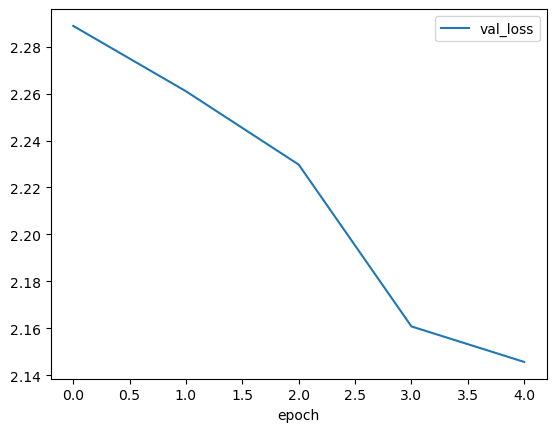

In [15]:
display(result_grid.get_dataframe())
best_results = result_grid.get_best_result("val_loss", "min")
display(best_results.metrics_dataframe)
best_results.metrics_dataframe.plot("epoch", "val_loss")

Text(0, 0.5, 'Mean Validation Loss')

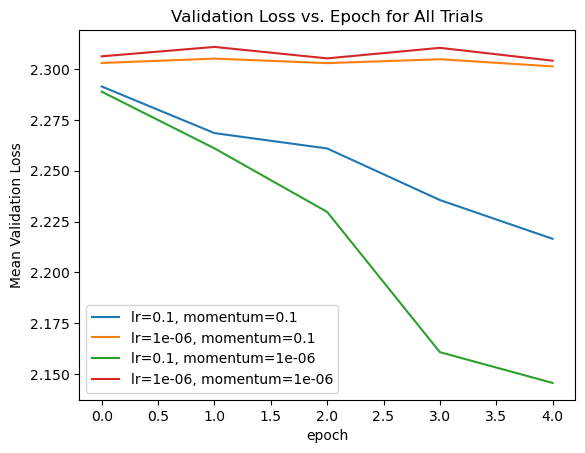

In [16]:
ax = None
for result in result_grid:
    parameters = result.config["lightning_config"]["_module_init_config"]["config"]["parameters"]
    label = f"lr={parameters['lr']}, momentum={parameters['weight_decay']}"
    if ax is None:
        ax = result.metrics_dataframe.plot("epoch", "val_loss", label=label)
    else:
        result.metrics_dataframe.plot("epoch", "val_loss", ax=ax, label=label)
ax.set_title("Validation Loss vs. Epoch for All Trials")
ax.set_ylabel("Mean Validation Loss")